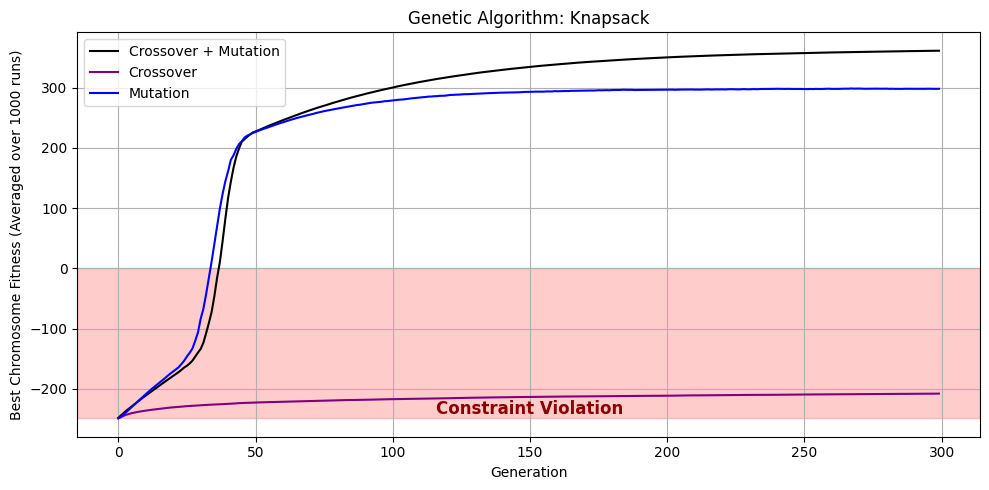

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class GA_knapsack:
    def __init__(self, n_items: int, n_chromosomes: int, n_elite: int, max_weight: int, weights: np.typing.NDArray, values: np.typing.NDArray, n_immigration: int, use_mutation: bool = True, use_crossover: bool = True):
        self.n_items = n_items
        self.n_chromosomes = n_chromosomes
        self.n_elite = n_elite
        self.max_weight = max_weight
        self.weights = weights
        self.values = values
        self.n_immigration = n_immigration
        self.use_mutation = use_mutation
        self.use_crossover = use_crossover


    def generate_boolarray(self, n_rows: int, n_cols: int):
        return np.random.randint(size=(n_rows, n_cols), low=0, high=2).astype(bool)


    def generate_random_chromosomes(self, n_chromosomes: int):
        return self.generate_boolarray(n_rows=n_chromosomes, n_cols=self.n_items)


    def mutate_chromosomes(self, chromosomes: np.typing.NDArray):
        """
        changes one randomly chosen gene per chromosome (by swapping its bit).
        """
        swap_positions = [np.arange(chromosomes.shape[0]), np.random.randint(high=chromosomes.shape[1], low=0, size=chromosomes.shape[0])]
        chromosomes[swap_positions[0], swap_positions[1]] = ~chromosomes[swap_positions[0], swap_positions[1]]
        return chromosomes
    

    def crossover(self, chromosomes: np.typing.NDArray):
        """
        per chromosome: randomly either take mothers or fathers gene in each chromosome position
        """
        chromosomes_mother = chromosomes[np.random.shuffle(np.arange(chromosomes.shape[0]))]  # randomly assign other chromosome as mother
        fathers_genes_mask = self.generate_boolarray(n_rows=chromosomes.shape[0], n_cols=chromosomes.shape[1])
        return np.where(fathers_genes_mask, chromosomes, chromosomes_mother)[0]


    def fitness_function(self, chromosomes: np.typing.NDArray):
        """
        if total weight < knapsack limit: 
            sum of item values
        else:
            inverse of the weight values

        This way, being overloaded leads to a lower score than having a single item with low value.
        Also, being heavily overloaded is punished stronger than being slightly overloaded.
        This way the algorihtm escapes situations faster, in which all chromosomes have overloaded knapsacks.
        """
        return (chromosomes @ self.values) * (chromosomes @ self.weights < self.max_weight) - (chromosomes @ self.weights >= self.max_weight) * (chromosomes @ self.weights)


    def selection(self, chromosomes):
        """
        prunes current generation by selecting some chromosomes and discarding others.
        Fitter chromosomes are more likely to survive.
        """
        fitness = self.fitness_function(chromosomes)
        fitness_argsorted = np.argsort(fitness)[::-1]
        ids_elite = fitness_argsorted[:self.n_elite]
        # first select elite
        chromosomes_elite = chromosomes[ids_elite]
        # draw otehr candidates, probability depends on their fitness (don't automatically discard low ranking chromosomes, because they might carry useful genes)
        candidates = fitness_argsorted[self.n_elite:]
        ranks = np.arange(len(candidates))      
        case_weights = 1 / (ranks + 1)
        probabilities = case_weights / case_weights.sum()
        chromosomes_selected = chromosomes[np.random.choice(candidates, size=self.n_chromosomes - self.n_elite, replace=False, p=probabilities)]
        return np.concatenate([chromosomes_elite, chromosomes_selected]), fitness.max()  # elite chromosomes are always in the first n_elite entries


    def run(self, n_iters: int):
        iter_max_fitness = []
        chromosomes = self.generate_random_chromosomes(n_chromosomes=self.n_chromosomes)
        for _ in range(n_iters):
            # elitism: best chromosomes are carried over to the next generation for stable convergence
            chromosomes_elite = chromosomes[:self.n_elite]  # elite chromosomes are always in the first n_elite entries

            # immigration: prevent getting stuck in local optimium by adding new random chromosomes (fast exploration, without exploiting current state)
            chromosomes_immigrated = self.generate_random_chromosomes(n_chromosomes=self.n_immigration)

            chromosomes_evolved = chromosomes
            # crossover: pairing two chromosomes (in this case: per position either take fathers or mothers gene)
            if self.use_crossover:
                chromosomes_evolved = self.crossover(chromosomes=chromosomes_evolved)

            # mutation: randomly changing single genes (slow exploration, with exploitation of current state)
            if self.use_mutation:
                chromosomes_evolved = self.mutate_chromosomes(chromosomes=chromosomes_evolved)

            # combine all sources of chromosomes and perform selection
            chromosomes = np.concat([chromosomes_elite, chromosomes_immigrated, chromosomes_evolved])
            chromosomes, max_fitness = self.selection(chromosomes=chromosomes)
            iter_max_fitness.append(max_fitness)
        return iter_max_fitness, chromosomes

            


def generate_knapsack_items(n_items: int):
    combined = np.random.randint(size=(2, n_items), low=1, high=11)
    return [combined[0], combined[1]]


n_runs = 1_000
n_iters = 300
n_items = 128
weights, values = generate_knapsack_items(n_items=n_items)
ga = GA_knapsack(
    n_chromosomes=64,
    n_immigration=16, 
    n_elite=16, 
    max_weight=int(weights.sum() * 0.2), 
    weights=weights, 
    values=values, 
    n_items=n_items)



# crossover + mutation
ga.use_mutation = True
ga.use_crossover = True
max_fitness_mean = np.zeros(n_iters)
for _ in range(n_runs):
    max_fitness, _ = ga.run(n_iters=n_iters)
    max_fitness_mean += max_fitness
max_fitness_mean_cm = max_fitness_mean / n_runs

# crossover
ga.use_mutation = False
ga.use_crossover = True
max_fitness_mean = np.zeros(n_iters)
for _ in range(n_runs):
    max_fitness, _ = ga.run(n_iters=n_iters)
    max_fitness_mean += max_fitness
max_fitness_mean_c = max_fitness_mean / n_runs

# mutation
ga.use_mutation = True
ga.use_crossover = False
max_fitness_mean = np.zeros(n_iters)
for _ in range(n_runs):
    max_fitness, _ = ga.run(n_iters=n_iters)
    max_fitness_mean += max_fitness
max_fitness_mean_m = max_fitness_mean / n_runs



# plot
plt.figure(figsize=(10, 5))
plt.plot(max_fitness_mean_cm, label='Crossover + Mutation', color='black')
plt.plot(max_fitness_mean_c, label='Crossover', color='purple')
plt.plot(max_fitness_mean_m, label='Mutation', color='blue')
plt.axhspan(ymin=min(min(max_fitness_mean_c), min(max_fitness_mean_m), min(max_fitness_mean_cm)), ymax=0, color='red', alpha=0.2)
plt.text(len(max_fitness_mean_c) / 2, min(max_fitness_mean_c) + 0.1, 'Constraint Violation',
         horizontalalignment='center',
         verticalalignment='bottom',
         fontsize=12,
         color='darkred',
         fontweight='bold')
plt.title("Genetic Algorithm: Knapsack")
plt.xlabel("Generation")
plt.ylabel("Best Chromosome Fitness (Averaged over 1000 runs)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()